In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [14]:
len(words)

32033

In [15]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [16]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size

        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X, Y = build_dataset(words)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [17]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))
for p in parameters: p.requires_grad = True

11897


In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i <= 100000 else 0.01
    # lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 28.4853


  10000/ 200000: 2.5550
  20000/ 200000: 2.3120
  30000/ 200000: 2.1579
  40000/ 200000: 2.3363
  50000/ 200000: 2.0092
  60000/ 200000: 2.2087
  70000/ 200000: 2.7739
  80000/ 200000: 2.3040
  90000/ 200000: 2.1150
 100000/ 200000: 2.3557
 110000/ 200000: 2.4808
 120000/ 200000: 1.7717
 130000/ 200000: 2.6023
 140000/ 200000: 1.8469
 150000/ 200000: 2.0481
 160000/ 200000: 2.3008
 170000/ 200000: 1.8745
 180000/ 200000: 1.8389
 190000/ 200000: 2.4760


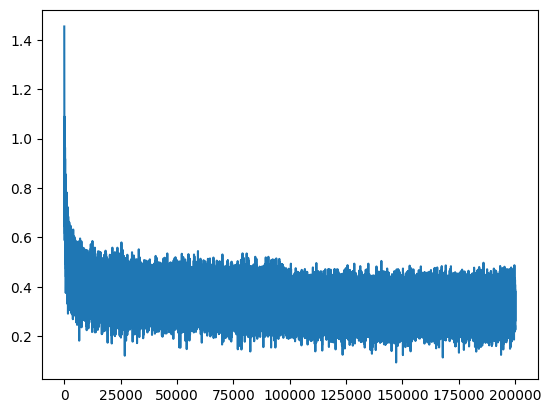

In [21]:
plt.plot(lossi)

In [22]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [23]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

tensor([[-10.3329,  -2.7176,  -4.4485,  ...,  -6.6144,  -5.2303,  -4.7298],
        [ -9.0624,   3.1561,  -3.4361,  ...,  -5.7024,  -1.3933,  -1.6416],
        [ -3.1999,   1.0887,  -0.1319,  ...,  -0.3079,  -1.2371,  -1.7142],
        ...,
        [  9.3806,   9.7511,   2.2378,  ...,   0.1430,   8.9167,   2.6098],
        [ 11.1793,   6.7826,   8.5198,  ...,   4.9520,   8.4116,   6.1096],
        [  9.4894,   9.0326,   1.4689,  ...,   3.7502,   7.7835,   5.1818]])
train 2.1307029724121094
tensor([[-10.3329,  -2.7176,  -4.4485,  ...,  -6.6144,  -5.2303,  -4.7298],
        [ -6.7225,  -0.1358,  -0.8055,  ...,  -2.5341,  -0.8201,  -0.8749],
        [ -2.7577,   4.9053,   1.9598,  ...,  -9.5757,   1.7793,  -1.9858],
        ...,
        [  6.8271,   7.4365,   5.1820,  ...,   0.7713,   3.8058,   4.9361],
        [  7.8182,  10.4989,   1.7374,  ...,  -2.7465,   8.8665,  -0.0771],
        [ 12.0651,   7.4677,   5.1749,  ...,  -4.0510,   9.1540,   4.7807]])
val 2.1694421768188477


In [36]:
for _ in range(1):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        # print(emb.view(-1, 30))
        # print(W1.shape)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        # print(logits)
        probs = F.softmax(logits, dim=1);
        ix = torch.multinomial(probs, num_samples=1).item()
        print(probs, ix)
        print(ix, probs[:, ix].item())
        
        prob_sum = 0
        for j in range(27):
            # print(j, itos[j], probs[:, j].item())
            prob_sum += probs[:, j].item()
        
        print(prob_sum)
        if ix == 0:
            break

        context = context[1:] + [ix]
        out.append(ix)

    print(''.join(itos[i] for i in out))

tensor([[9.4688e-05, 1.9212e-01, 3.4030e-02, 3.6784e-02, 6.4733e-02, 5.5166e-02,
         1.1140e-02, 2.1178e-02, 3.8174e-02, 1.5663e-02, 5.8227e-02, 7.1532e-02,
         5.6972e-02, 6.2105e-02, 2.7238e-02, 9.8186e-03, 1.4629e-02, 2.6376e-03,
         5.3131e-02, 6.3328e-02, 4.3415e-02, 2.0163e-03, 8.2287e-03, 1.2478e-02,
         3.9016e-03, 1.5571e-02, 2.5685e-02]], grad_fn=<SoftmaxBackward0>) 8
8 0.038174327462911606
1.0000000257859938
tensor([[5.8908e-06, 7.1281e-01, 2.1314e-04, 3.3964e-03, 6.4689e-04, 1.1782e-01,
         4.5709e-05, 9.2192e-05, 1.2563e-03, 2.6980e-02, 4.8229e-05, 7.4333e-04,
         2.3025e-04, 2.5471e-04, 2.2350e-03, 6.5910e-02, 5.1014e-07, 7.5300e-08,
         1.1875e-03, 1.3459e-03, 6.8191e-04, 5.2290e-02, 3.2009e-04, 1.4286e-03,
         6.3847e-07, 9.9944e-03, 5.9440e-05]], grad_fn=<SoftmaxBackward0>) 9
9 0.026979884132742882
0.9999999953393655
tensor([[2.9642e-03, 1.8584e-01, 4.0803e-03, 7.8024e-02, 6.0896e-02, 1.5305e-02,
         8.2972e-06, 3.7857e-03, 